In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Define the repository URL and the local directory where you want to clone/pull the repository
repo_url = 'https://github.com/aakashvardhan/s10-residual-ocp.git'
local_dir = '/content/s10-residual-ocp'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

# !git clone 'https://github.com/aakashvardhan/s10-residual-ocp.git'

Cloning into 's10-residual-ocp'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 103 (delta 47), reused 73 (delta 19), pack-reused 0
Receiving objects: 100% (103/103), 104.57 KiB | 787.00 KiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
import sys
sys.path.append('/content/s10-residual-ocp')
sys.path.append('/content/s10-residual-ocp/models')

In [4]:
!pip install torch-lr-finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00


In [5]:
from config import get_config
config = get_config()
from main import main
import torch
from utils import set_seeds
from setup_cifar10 import setup_cifar10
from torch_lr_finder import LRFinder
from models.custom_resnet import CustomResNet
from models.model_utils import model_summary, adam_optimizer
import torch.nn as nn
set_seeds()

In [6]:
config['epochs'] = 24
config['lr_scheduler'] = 'one_cycle'
config['lr'] = 0.001

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          Identity-2           [-1, 64, 32, 32]               0
          Identity-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
           Dropout-6           [-1, 64, 32, 32]               0
         ConvBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,728
         MaxPool2d-9          [-1, 128, 16, 16]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
      

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


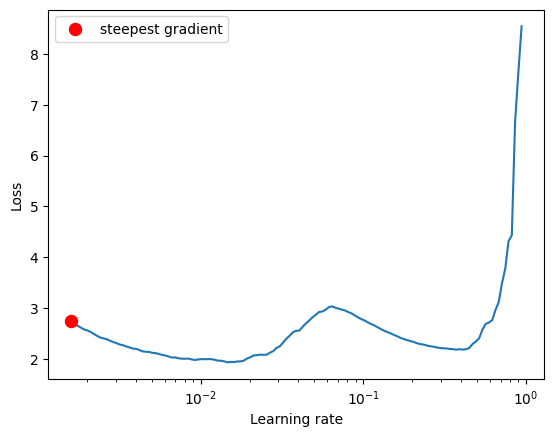

In [8]:
criterion = nn.CrossEntropyLoss()
train_data, test_data, train_loader, test_loader = setup_cifar10(config)
model = CustomResNet(config).to(config["device"])
model_summary(model, input_size=(3, 32, 32))
optimizer = adam_optimizer(model, config)
lr_finder = LRFinder(model, optimizer, criterion, device=config["device"])
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

In [9]:
config['max_lr'] = 1.59E-03

In [10]:
lr = main(config, model, train_loader, test_loader, optimizer, criterion)

EPOCH: 1


Loss=2.966447591781616 Batch_id=2 Accuracy=10.94:   1%|          | 3/391 [00:00<01:02,  6.24it/s]

Max Learning Rate: 1.670557830092119e-05
Max Learning Rate: 1.7511156601842377e-05
Max Learning Rate: 1.831673490276356e-05


Loss=2.5248687267303467 Batch_id=6 Accuracy=10.38:   1%|▏         | 5/391 [00:00<00:45,  8.57it/s]

Max Learning Rate: 1.912231320368475e-05
Max Learning Rate: 1.9927891504605938e-05
Max Learning Rate: 2.0733469805527122e-05


Loss=2.5156090259552 Batch_id=9 Accuracy=11.17:   2%|▏         | 9/391 [00:01<00:30, 12.33it/s]  

Max Learning Rate: 2.1539048106448314e-05
Max Learning Rate: 2.23446264073695e-05
Max Learning Rate: 2.3150204708290687e-05
Max Learning Rate: 2.3955783009211875e-05


Loss=2.314069986343384 Batch_id=13 Accuracy=12.95:   3%|▎         | 13/391 [00:01<00:25, 14.75it/s] 

Max Learning Rate: 2.476136131013306e-05
Max Learning Rate: 2.5566939611054248e-05
Max Learning Rate: 2.6372517911975436e-05
Max Learning Rate: 2.7178096212896624e-05


Loss=2.149735450744629 Batch_id=17 Accuracy=14.37:   4%|▍         | 17/391 [00:01<00:23, 16.22it/s] 

Max Learning Rate: 2.7983674513817812e-05
Max Learning Rate: 2.8789252814738997e-05
Max Learning Rate: 2.9594831115660185e-05
Max Learning Rate: 3.0400409416581374e-05


Loss=2.1255288124084473 Batch_id=21 Accuracy=15.62:   5%|▌         | 21/391 [00:01<00:22, 16.39it/s]

Max Learning Rate: 3.120598771750256e-05
Max Learning Rate: 3.201156601842375e-05
Max Learning Rate: 3.2817144319344935e-05
Max Learning Rate: 3.3622722620266126e-05


Loss=2.0260379314422607 Batch_id=25 Accuracy=16.89:   6%|▋         | 25/391 [00:01<00:21, 16.87it/s]

Max Learning Rate: 3.442830092118731e-05
Max Learning Rate: 3.5233879222108496e-05
Max Learning Rate: 3.603945752302969e-05
Max Learning Rate: 3.684503582395087e-05


Loss=2.0594213008880615 Batch_id=29 Accuracy=17.92:   7%|▋         | 29/391 [00:02<00:21, 16.50it/s]

Max Learning Rate: 3.765061412487206e-05
Max Learning Rate: 3.845619242579325e-05
Max Learning Rate: 3.926177072671443e-05
Max Learning Rate: 4.006734902763562e-05


Loss=1.9047261476516724 Batch_id=33 Accuracy=18.96:   8%|▊         | 33/391 [00:02<00:21, 16.95it/s]

Max Learning Rate: 4.087292732855681e-05
Max Learning Rate: 4.1678505629478e-05
Max Learning Rate: 4.248408393039918e-05
Max Learning Rate: 4.328966223132037e-05


Loss=1.8880952596664429 Batch_id=37 Accuracy=19.88:   9%|▉         | 37/391 [00:02<00:20, 17.07it/s]

Max Learning Rate: 4.409524053224156e-05
Max Learning Rate: 4.490081883316274e-05
Max Learning Rate: 4.570639713408393e-05
Max Learning Rate: 4.6511975435005116e-05


Loss=1.9632779359817505 Batch_id=41 Accuracy=20.80:  10%|█         | 41/391 [00:02<00:19, 17.52it/s]

Max Learning Rate: 4.731755373592631e-05
Max Learning Rate: 4.81231320368475e-05
Max Learning Rate: 4.8928710337768684e-05
Max Learning Rate: 4.973428863868987e-05


Loss=1.823009967803955 Batch_id=46 Accuracy=21.96:  12%|█▏        | 46/391 [00:03<00:18, 18.37it/s] 

Max Learning Rate: 5.0539866939611054e-05
Max Learning Rate: 5.1345445240532245e-05
Max Learning Rate: 5.215102354145344e-05
Max Learning Rate: 5.295660184237462e-05
Max Learning Rate: 5.3762180143295806e-05


Loss=1.9529905319213867 Batch_id=51 Accuracy=22.81:  13%|█▎        | 51/391 [00:03<00:17, 19.29it/s]

Max Learning Rate: 5.456775844421699e-05
Max Learning Rate: 5.537333674513818e-05
Max Learning Rate: 5.6178915046059374e-05
Max Learning Rate: 5.698449334698056e-05
Max Learning Rate: 5.7790071647901744e-05


Loss=1.7403998374938965 Batch_id=56 Accuracy=23.68:  14%|█▍        | 56/391 [00:03<00:16, 19.81it/s]

Max Learning Rate: 5.859564994882293e-05
Max Learning Rate: 5.940122824974412e-05
Max Learning Rate: 6.0206806550665305e-05
Max Learning Rate: 6.1012384851586496e-05
Max Learning Rate: 6.181796315250768e-05


Loss=1.7187598943710327 Batch_id=61 Accuracy=24.53:  16%|█▌        | 61/391 [00:03<00:16, 19.99it/s]

Max Learning Rate: 6.262354145342887e-05
Max Learning Rate: 6.342911975435006e-05
Max Learning Rate: 6.423469805527124e-05
Max Learning Rate: 6.504027635619243e-05


Loss=1.6424452066421509 Batch_id=65 Accuracy=25.33:  17%|█▋        | 65/391 [00:04<00:16, 19.60it/s]

Max Learning Rate: 6.584585465711361e-05
Max Learning Rate: 6.66514329580348e-05
Max Learning Rate: 6.7457011258956e-05
Max Learning Rate: 6.826258955987719e-05
Max Learning Rate: 6.906816786079836e-05

Loss=1.510337471961975 Batch_id=69 Accuracy=26.24:  18%|█▊        | 70/391 [00:04<00:16, 19.79it/s]


Max Learning Rate: 6.987374616171954e-05
Max Learning Rate: 7.067932446264073e-05
Max Learning Rate: 7.148490276356193e-05
Max Learning Rate: 7.229048106448312e-05


Loss=1.6052515506744385 Batch_id=74 Accuracy=26.90:  19%|█▉        | 75/391 [00:04<00:15, 20.07it/s]

Max Learning Rate: 7.309605936540431e-05
Max Learning Rate: 7.390163766632549e-05
Max Learning Rate: 7.470721596724668e-05
Max Learning Rate: 7.551279426816787e-05
Max Learning Rate: 7.631837256908906e-05


Loss=1.5976859331130981 Batch_id=79 Accuracy=27.77:  20%|█▉        | 78/391 [00:04<00:15, 20.25it/s]

Max Learning Rate: 7.712395087001024e-05
Max Learning Rate: 7.792952917093143e-05
Max Learning Rate: 7.873510747185262e-05
Max Learning Rate: 7.954068577277381e-05
Max Learning Rate: 8.0346264073695e-05


Loss=1.5778872966766357 Batch_id=83 Accuracy=28.44:  21%|██        | 83/391 [00:04<00:15, 19.63it/s]

Max Learning Rate: 8.115184237461617e-05
Max Learning Rate: 8.195742067553736e-05
Max Learning Rate: 8.276299897645855e-05
Max Learning Rate: 8.356857727737974e-05


Loss=1.770499587059021 Batch_id=88 Accuracy=29.26:  23%|██▎       | 89/391 [00:05<00:15, 19.96it/s]

Max Learning Rate: 8.437415557830094e-05
Max Learning Rate: 8.51797338792221e-05
Max Learning Rate: 8.598531218014329e-05
Max Learning Rate: 8.679089048106448e-05
Max Learning Rate: 8.759646878198568e-05


Loss=1.4537395238876343 Batch_id=93 Accuracy=29.97:  24%|██▍       | 94/391 [00:05<00:14, 20.05it/s]

Max Learning Rate: 8.840204708290687e-05
Max Learning Rate: 8.920762538382806e-05
Max Learning Rate: 9.001320368474925e-05
Max Learning Rate: 9.081878198567041e-05
Max Learning Rate: 9.16243602865916e-05


Loss=1.5008589029312134 Batch_id=98 Accuracy=30.57:  25%|██▌       | 99/391 [00:05<00:14, 19.93it/s]

Max Learning Rate: 9.24299385875128e-05
Max Learning Rate: 9.323551688843399e-05
Max Learning Rate: 9.404109518935518e-05
Max Learning Rate: 9.484667349027637e-05
Max Learning Rate: 9.565225179119756e-05


Loss=1.540631651878357 Batch_id=102 Accuracy=31.30:  26%|██▋       | 103/391 [00:05<00:14, 19.77it/s]

Max Learning Rate: 9.645783009211876e-05
Max Learning Rate: 9.726340839303992e-05
Max Learning Rate: 9.806898669396111e-05
Max Learning Rate: 9.88745649948823e-05


Loss=1.3600962162017822 Batch_id=107 Accuracy=31.93:  28%|██▊       | 108/391 [00:06<00:14, 19.77it/s]

Max Learning Rate: 9.96801432958035e-05
Max Learning Rate: 0.00010048572159672469
Max Learning Rate: 0.00010129129989764585
Max Learning Rate: 0.00010209687819856704
Max Learning Rate: 0.00010290245649948823


Loss=1.3741432428359985 Batch_id=112 Accuracy=32.43:  29%|██▉       | 113/391 [00:06<00:13, 19.87it/s]

Max Learning Rate: 0.00010370803480040942
Max Learning Rate: 0.00010451361310133062
Max Learning Rate: 0.00010531919140225181
Max Learning Rate: 0.000106124769703173
Max Learning Rate: 0.00010693034800409416


Loss=1.3854763507843018 Batch_id=117 Accuracy=33.00:  30%|██▉       | 117/391 [00:06<00:13, 19.59it/s]

Max Learning Rate: 0.00010773592630501536
Max Learning Rate: 0.00010854150460593655
Max Learning Rate: 0.00010934708290685774
Max Learning Rate: 0.00011015266120777893


Loss=1.5319620370864868 Batch_id=120 Accuracy=33.36:  31%|███       | 121/391 [00:06<00:14, 19.17it/s]

Max Learning Rate: 0.00011095823950870012
Max Learning Rate: 0.00011176381780962131
Max Learning Rate: 0.00011256939611054248
Max Learning Rate: 0.00011337497441146367


Loss=1.4530411958694458 Batch_id=124 Accuracy=33.79:  32%|███▏      | 125/391 [00:07<00:13, 19.08it/s]

Max Learning Rate: 0.00011418055271238486
Max Learning Rate: 0.00011498613101330605
Max Learning Rate: 0.00011579170931422722
Max Learning Rate: 0.00011659728761514841


Loss=1.4589787721633911 Batch_id=128 Accuracy=34.20:  33%|███▎      | 129/391 [00:07<00:13, 19.10it/s]

Max Learning Rate: 0.0001174028659160696
Max Learning Rate: 0.00011820844421699079
Max Learning Rate: 0.00011901402251791198
Max Learning Rate: 0.00011981960081883317


Loss=1.595852017402649 Batch_id=132 Accuracy=34.55:  34%|███▍      | 133/391 [00:07<00:13, 19.05it/s]

Max Learning Rate: 0.00012062517911975437
Max Learning Rate: 0.00012143075742067556
Max Learning Rate: 0.00012223633572159672
Max Learning Rate: 0.00012304191402251791


Loss=1.463188886642456 Batch_id=137 Accuracy=35.13:  35%|███▌      | 137/391 [00:07<00:13, 19.44it/s] 

Max Learning Rate: 0.0001238474923234391
Max Learning Rate: 0.0001246530706243603
Max Learning Rate: 0.0001254586489252815
Max Learning Rate: 0.00012626422722620268
Max Learning Rate: 0.00012706980552712387


Loss=1.4381788969039917 Batch_id=142 Accuracy=35.65:  37%|███▋      | 143/391 [00:07<00:12, 19.98it/s]

Max Learning Rate: 0.00012787538382804506
Max Learning Rate: 0.00012868096212896625
Max Learning Rate: 0.00012948654042988742
Max Learning Rate: 0.0001302921187308086
Max Learning Rate: 0.0001310976970317298


Loss=1.4537115097045898 Batch_id=146 Accuracy=36.03:  38%|███▊      | 147/391 [00:08<00:12, 19.45it/s]

Max Learning Rate: 0.00013190327533265097
Max Learning Rate: 0.00013270885363357216
Max Learning Rate: 0.00013351443193449335
Max Learning Rate: 0.00013432001023541454


Loss=1.3062984943389893 Batch_id=151 Accuracy=36.61:  39%|███▉      | 152/391 [00:08<00:12, 19.89it/s]

Max Learning Rate: 0.00013512558853633573
Max Learning Rate: 0.00013593116683725692
Max Learning Rate: 0.00013673674513817812
Max Learning Rate: 0.0001375423234390993
Max Learning Rate: 0.00013834790174002047


Loss=1.3535032272338867 Batch_id=156 Accuracy=37.12:  40%|███▉      | 156/391 [00:08<00:12, 19.56it/s]

Max Learning Rate: 0.00013915348004094166
Max Learning Rate: 0.00013995905834186285
Max Learning Rate: 0.00014076463664278405
Max Learning Rate: 0.00014157021494370524
Max Learning Rate: 0.00014237579324462643


Loss=1.3310141563415527 Batch_id=161 Accuracy=37.51:  41%|████      | 161/391 [00:08<00:11, 19.81it/s]

Max Learning Rate: 0.00014318137154554762
Max Learning Rate: 0.0001439869498464688
Max Learning Rate: 0.00014479252814739
Max Learning Rate: 0.0001455981064483112
Max Learning Rate: 0.00014640368474923236


Loss=1.2712056636810303 Batch_id=165 Accuracy=37.80:  42%|████▏     | 166/391 [00:09<00:11, 19.91it/s]

Max Learning Rate: 0.00014720926305015355
Max Learning Rate: 0.00014801484135107474
Max Learning Rate: 0.00014882041965199593
Max Learning Rate: 0.00014962599795291713


Loss=1.6213146448135376 Batch_id=170 Accuracy=38.06:  43%|████▎     | 168/391 [00:09<00:11, 19.73it/s]

Max Learning Rate: 0.0001504315762538383
Max Learning Rate: 0.00015123715455475948
Max Learning Rate: 0.00015204273285568067
Max Learning Rate: 0.00015284831115660187
Max Learning Rate: 0.00015365388945752303

Loss=1.4979581832885742 Batch_id=173 Accuracy=38.26:  44%|████▍     | 173/391 [00:09<00:11, 19.56it/s]


Max Learning Rate: 0.00015445946775844422
Max Learning Rate: 0.0001552650460593654
Max Learning Rate: 0.0001560706243602866


Loss=1.339377999305725 Batch_id=177 Accuracy=38.57:  46%|████▌     | 178/391 [00:09<00:10, 19.55it/s]

Max Learning Rate: 0.0001568762026612078
Max Learning Rate: 0.000157681780962129
Max Learning Rate: 0.00015848735926305018
Max Learning Rate: 0.00015929293756397137


Loss=1.141845703125 Batch_id=181 Accuracy=38.87:  47%|████▋     | 182/391 [00:09<00:10, 19.62it/s]

Max Learning Rate: 0.00016009851586489256
Max Learning Rate: 0.00016090409416581375
Max Learning Rate: 0.00016170967246673492
Max Learning Rate: 0.0001625152507676561


Loss=1.3213216066360474 Batch_id=185 Accuracy=39.16:  48%|████▊     | 186/391 [00:10<00:10, 19.24it/s]

Max Learning Rate: 0.0001633208290685773
Max Learning Rate: 0.0001641264073694985
Max Learning Rate: 0.00016493198567041968
Max Learning Rate: 0.00016573756397134085


Loss=1.3704736232757568 Batch_id=190 Accuracy=39.47:  49%|████▉     | 191/391 [00:10<00:10, 19.73it/s]

Max Learning Rate: 0.00016654314227226204
Max Learning Rate: 0.00016734872057318323
Max Learning Rate: 0.00016815429887410442
Max Learning Rate: 0.00016895987717502561
Max Learning Rate: 0.00016976545547594678


Loss=1.3270066976547241 Batch_id=195 Accuracy=39.84:  50%|████▉     | 194/391 [00:10<00:09, 19.82it/s]

Max Learning Rate: 0.00017057103377686797
Max Learning Rate: 0.00017137661207778916
Max Learning Rate: 0.00017218219037871035
Max Learning Rate: 0.00017298776867963155
Max Learning Rate: 0.00017379334698055274


Loss=1.2236847877502441 Batch_id=200 Accuracy=40.15:  51%|█████     | 200/391 [00:10<00:09, 20.09it/s]

Max Learning Rate: 0.00017459892528147393
Max Learning Rate: 0.00017540450358239512
Max Learning Rate: 0.0001762100818833163
Max Learning Rate: 0.0001770156601842375
Max Learning Rate: 0.00017782123848515867


Loss=1.3805642127990723 Batch_id=205 Accuracy=40.41:  53%|█████▎    | 206/391 [00:11<00:09, 20.06it/s]

Max Learning Rate: 0.00017862681678607986
Max Learning Rate: 0.00017943239508700105
Max Learning Rate: 0.00018023797338792224
Max Learning Rate: 0.00018104355168884343
Max Learning Rate: 0.0001818491299897646


Loss=1.340419888496399 Batch_id=210 Accuracy=40.65:  53%|█████▎    | 209/391 [00:11<00:09, 19.89it/s]

Max Learning Rate: 0.0001826547082906858
Max Learning Rate: 0.00018346028659160698
Max Learning Rate: 0.00018426586489252817
Max Learning Rate: 0.00018507144319344936
Max Learning Rate: 0.00018587702149437053


Loss=1.3481354713439941 Batch_id=215 Accuracy=40.99:  55%|█████▍    | 215/391 [00:11<00:08, 20.05it/s]

Max Learning Rate: 0.00018668259979529172
Max Learning Rate: 0.0001874881780962129
Max Learning Rate: 0.0001882937563971341
Max Learning Rate: 0.0001890993346980553
Max Learning Rate: 0.0001899049129989765


Loss=1.125394582748413 Batch_id=220 Accuracy=41.35:  57%|█████▋    | 221/391 [00:11<00:08, 20.30it/s]

Max Learning Rate: 0.00019071049129989768
Max Learning Rate: 0.00019151606960081887
Max Learning Rate: 0.00019232164790174006
Max Learning Rate: 0.00019312722620266123
Max Learning Rate: 0.00019393280450358242


Loss=1.2930974960327148 Batch_id=224 Accuracy=41.43:  57%|█████▋    | 224/391 [00:12<00:08, 20.14it/s]

Max Learning Rate: 0.0001947383828045036
Max Learning Rate: 0.0001955439611054248
Max Learning Rate: 0.000196349539406346
Max Learning Rate: 0.00019715511770726716


Loss=1.1674387454986572 Batch_id=225 Accuracy=41.51:  58%|█████▊    | 226/391 [00:12<00:08, 18.39it/s]

Max Learning Rate: 0.00019796069600818835


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from utils import plt_fig
plt_fig()

In [ ]:
from visualize import show_misclassified_images, plt_misclassified_images

In [ ]:
misclass_imgs, misclass_targets, misclass_preds = show_misclassified_images(model, test_loader, config)
plt_misclassified_images(config, misclass_imgs, misclass_targets, misclass_preds)